## Introduction

This notebook simulates freight trips and generates a freight population file.

The following steps are undertaken:

1. Read, process, and plot data.
2. Input Assumptions & Sampler Creation
3. Create Activity Model & Population
4. Validation

In [1]:
import pandas as pd
import geopandas as gp
import matplotlib
from matplotlib import pyplot as plt
import random
from datetime import date
import numpy as np
import os
from scipy import spatial

from pam.core import Population, Household, Person
from pam.plot.stats import plot_activity_times, plot_leg_times
from pam.samplers.facility import FacilitySampler
from pam.samplers import tour
from pam.variables import END_OF_DAY
from pam.write import write_matsim, write_od_matrices

matplotlib.style.use('ggplot')

In [2]:
output_path = './data/outputs'

## 1. Read, process, plot Data
Below, we load in data required to build a tour plan: zones and facilities data.

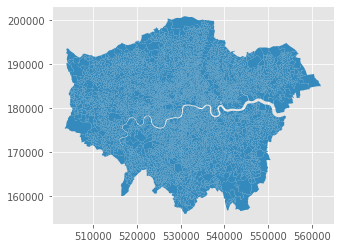

In [3]:
zones = gp.read_file('./data/lsoas/LSOA_2004_London_Low_Resolution.shp')
zones.set_crs('EPSG:27700', allow_override=True, inplace=True)
zones.rename(columns={'LSOA_CODE':'zone'}, inplace=True)
zones.plot()
plt.show()

<AxesSubplot:>

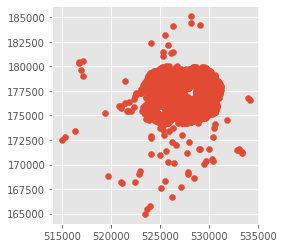

In [4]:
# load facilities
facilities = gp.read_file('./data/londinium_facilities_sample.geojson')
facilities.set_crs('EPSG:27700', allow_override=True, inplace=True)

# dummy create depots and deliveries
facilities['activity'] = np.where(facilities['activity']=='shop', 'depot', facilities['activity'])
facilities['activity'] = np.where(facilities['activity']=='leisure', 'delivery', facilities['activity'])

facilities.plot()

The zones data is for all of London, below, we crop the zones data to the Londinium study area.

In [5]:
cols = list(zones.columns)

zones_londinium = gp.sjoin(zones, facilities, how='inner', predicate='intersects')
zones_londinium = zones_londinium[cols]
zones = zones_londinium.drop_duplicates()
zones = zones.set_index('zone')

In [6]:
facility_sampler = FacilitySampler(
    facilities=facilities,
    zones=zones,
    build_xml=True,
    fail=False,
    random_default=True
)

facility_sampler.activities

Joining facilities data to zones, this may take a while.
/var/folders/fg/4rbdps2s6ss9r2455xhzwd4sswl1dp/T/ipykernel_9785/930579154.py:1: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

Building sampler, this may take a while.


['transit',
 'home',
 'pub',
 'other',
 'gym',
 'depot',
 'park',
 'education',
 'medical',
 'delivery',
 'work']

In [7]:
# Create a facility zone dataset to be used in samplers
facility_zone = gp.sjoin(facilities, zones, how='inner', predicate='intersects')
facility_zone.rename(columns={'index_right':'zone'}, inplace = True)
facility_zone.set_index('zone', inplace = True)

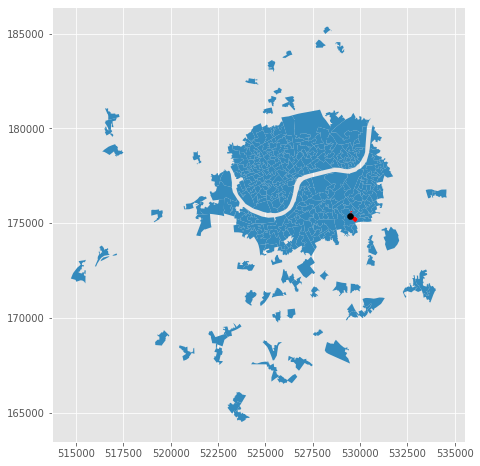

In [8]:
def plot_facility(zone_idx, activity):
    
    fig, ax = plt.subplots(figsize=(8,8))
    zones.plot(ax=ax)
    zones.loc[[zone_idx]].plot(color='red', ax=ax)
    
    facility_sampler.clear()
    point = facility_sampler.sample(zone_idx, activity)
    ax.scatter(point.x, point.y, color='black')
    plt.show()
    
plot_facility(random.choice(zones.index), 'depot')

## 2. Input Assumptions
We create a series of samplers that will serve as inputs into the activity model. These samplers include:
- Number of Stops
- Freight Hourly Demand
- Origin (in this case, Depot) location

#### Number of Stops
Build a Stop Number distribution and corresponding sampler.

In [9]:
bins = range(3,12)
pivots = {3: 36.0, 4: 28.0, 5: 15.0, 6: 7.0, 7: 4.0, 8: 2.5, 9: 2.5, 10: 1.0, 11: 4.0}
stop_sampler = tour.PivotDistributionSampler(bins=bins,pivots=pivots)
stop_sampler

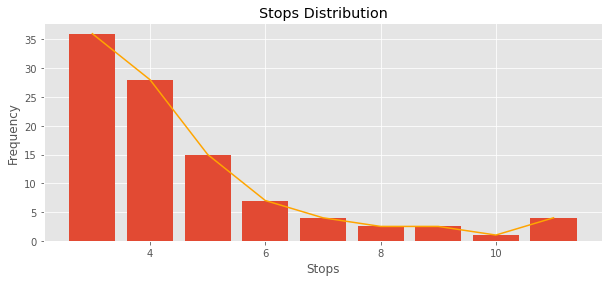

In [10]:
stop_sampler.plot(plot_title='Stops Distribution', x_label='Stops', y_label='Frequency')

#### Freight Hourly Demand
Hourly demand is a distribution created based on the pivots input. We use the class PivotDistributionSampler to translate 'pivots' into a distribution, plot, and sampler.

In [11]:
# Set up freight params for both LGV and HGV movements
lgv_params = {'total':2500,
              'pivots': {7: 14, 8 :9, 9: 13, 10: 16, 11: 18, 12: 13, 13: 15, 14: 16, 15: 14, 16: 13, 17: 9, 18: 5, 19: 3, 20: 3, 21: 3, 22: 2},
              'agent_id': 'LGV',
              'agent_attributes': 'lgv'
              }

hgv_params = {'total':1000,
              'pivots': {7: 2, 8: 1, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 1, 17: 1, 18: 0, 19: 1, 20: 1, 21: 1, 22: 1},
              'agent_id': 'HGV',
              'agent_attributes': 'hgv'
              }

Below, we decide if we will use the LGV or HGV parameters defined above.

In [12]:
freight_params = lgv_params.copy()

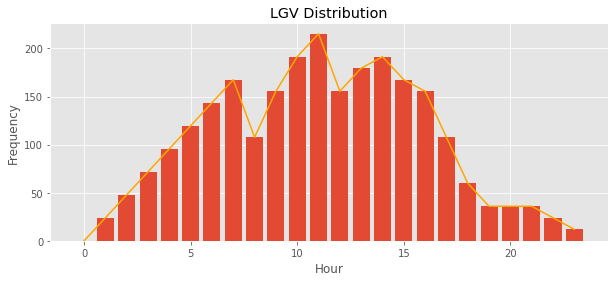

In [13]:
# Create Distribution
bins = range(0,24)

hour_sampler = tour.PivotDistributionSampler(bins=bins, pivots=freight_params['pivots'], total=freight_params['total'])
hour_sampler.plot(plot_title=f"{freight_params['agent_id']} Distribution", x_label='Hour', y_label='Frequency')

In [14]:
# Create a minute sampler
minute_sampler = tour.FrequencySampler(range(60))
minute_sampler.sample()

57

#### Input Demand & Constraints
We calculate the density of depots and deliveries across all zones. This information will be utilised by the class FrequencySampler to create a distribution. We also create an origin/destination matrix of distances between centroids that will be used to selected the destination locations.

In [15]:
origin_density = tour.create_density_gdf(facility_zone=facility_zone, zone=zones, activity=['depot'])
destination_density = tour.create_density_gdf(facility_zone=facility_zone, zone=zones, activity=['delivery'])

In [16]:
# Input Demand, in this case defined as facility density location
depot_sampler = tour.FrequencySampler(origin_density.index, origin_density.density)

In [17]:
# Constraint, defined as distance between origin and destination centroids. This dataframe will be filtered based on threshold values defined later.                                                                    
zones_list = zones.centroid.apply(lambda x: [x.x, x.y]).to_list()
od_matrix = spatial.distance_matrix(x=zones_list, y=zones_list)
df_od = pd.DataFrame(od_matrix, index=zones.index, columns=zones.index)

## 3. Activity Modeller

Parameters are defined to model a population of activity plans. Activities are encoded as "car". Subpopulation is encoded as "lgv" or "hgv".

#### Population Parameters

In [18]:
# Factor to scale trips (To better match validation counts when needed)
factor = 1 #0.70

# Sample Size
samples = [0.10]

# Set Distance threshold, in this case arbitrarily set to median distance of od dataframe.
threshold_value = df_od.median().agg('median')

# used for fnames
today = date.today().strftime('%d%b%y')
today

'14Jun22'

#### Activity Modeller

In [19]:
#### Sample Agents
def sample_agents(size):
    
    facility_sampler.clear()
    population = Population()
    
    for i in range(size):

        agent_id = f"{freight_params['agent_id']}_{i}"
        
        hh = Household(agent_id)
        
        agent = Person(
            agent_id,
            attributes={
                'subpopulation': freight_params['agent_attributes'],
                'CarType': freight_params['agent_attributes'],
                'CarCO2': freight_params['agent_attributes']
            }
        )
        
        hh.add(agent)
        population.add(hh)

        hour = hour_sampler.sample()
        minute = minute_sampler.sample()

        if freight_params['agent_id']=='LGV':
            stops = stop_sampler.sample()
        else:
            stops = 1

        agent_plan = tour.TourPlanner(stops=stops,
                                      hour_sampler=hour,
                                      minute_sampler=minute,
                                      o_start='depot',
                                      o_sampler=depot_sampler,
                                      threshold_matrix=df_od,
                                      d_dist=destination_density,
                                      d_freq='density', 
                                      threshold_value=threshold_value, 
                                      facility_sampler=facility_sampler,
                                      activity_params={'o_activity':'depot', 'd_activity':'delivery'})
        
        o_zone, o_loc, d_zones, d_locs = agent_plan.sequence_stops()
        agent_plan.apply(agent=agent, o_zone=o_zone, o_loc=o_loc, d_zones=d_zones, d_locs=d_locs)
      
    return population


In [20]:
# Function to build population 

def build_population(sample, factor):
    population = sample_agents(int(factor * int(freight_params['total'] * sample)))
    
    return population

In [21]:
# Build + Crop + Write Population for samples
for s in samples:
    
    #build
    population = build_population(s, factor)
        
    #Crop and Validate Plans
    population.fix_plans()
    population.validate()

    # Write to Disk
    xml_comment = f"prelim {s*100}% {freight_params['agent_id']} {today}"
    output_path = os.path.join(output_path)
    
    write_matsim(
        population,
        os.path.join(output_path, "plans.xml"),
        os.path.join(output_path, "attributes.xml"),
        comment=xml_comment
    )

    population.to_csv(output_path, crs = "EPSG:27700", to_crs="EPSG:4326")

    facility_sampler.write_facilities_xml(
       os.path.join(output_path, "facilities.xml"),
       comment=xml_comment
    )

Cropping plan components
Cropping plan ending in Leg
/Users/divya.sharma/Documents/repos/pam/venv/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/divya.sharma/Documents/repos/pam/venv/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



## 4. Validation

Person: LGV_78
{'subpopulation': 'lgv', 'CarType': 'lgv', 'CarCO2': 'lgv', 'hid': 'LGV_78'}
0:	Activity(1 act:depot, location:POINT (525597.0672998454 179791.15981818142), time:00:00:00 --> 05:50:00, duration:5:50:00)
1:	Leg(1 mode:car, area:POINT (525597.0672998454 179791.15981818142) --> POINT (524860.2743392407 176303.62064289142), time:05:50:00 --> 05:57:00, duration:0:07:00)
2:	Activity(2 act:delivery, location:POINT (524860.2743392407 176303.62064289142), time:05:57:00 --> 06:07:00, duration:0:10:00)
3:	Leg(2 mode:car, area:POINT (524860.2743392407 176303.62064289142) --> POINT (523496.56361112784 178051.78350513557), time:06:07:00 --> 06:12:00, duration:0:05:00)
4:	Activity(3 act:delivery, location:POINT (523496.56361112784 178051.78350513557), time:06:12:00 --> 06:22:00, duration:0:10:00)
5:	Leg(3 mode:car, area:POINT (523496.56361112784 178051.78350513557) --> POINT (524822.843104023 178004.77628285188), time:06:22:00 --> 06:26:00, duration:0:04:00)
6:	Activity(4 act:delivery,

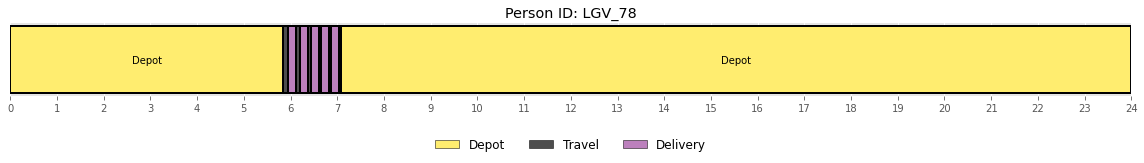

In [22]:
for i in range(1):
    p = population.random_person()
    p.plot()
    p.print()
    plt.show()

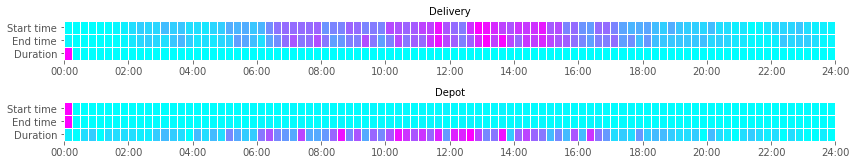

In [23]:
from pam.plot.stats import plot_activity_times, plot_leg_times
fig = plot_activity_times(population)
plt.show()

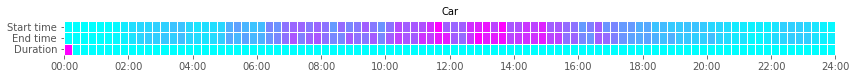

In [24]:
fig = plot_leg_times(population)
plt.show()

In [25]:
trips = pd.read_csv(os.path.join(output_path,"legs.csv"))

def get_hour(dt):
    return int(dt.split(" ")[1].split(":")[0])

trips["start_hour"] = trips["tst"].apply(get_hour)

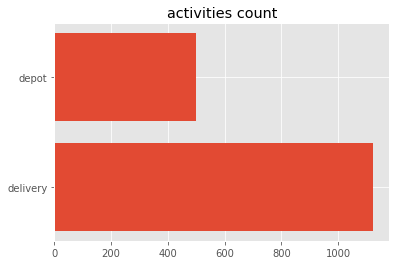

In [26]:
df_activity = pd.read_csv(os.path.join(output_path, "activities.csv"))
totals = df_activity.activity.value_counts()
plt.barh(totals.index, totals)
plt.title("activities count")
plt.show()

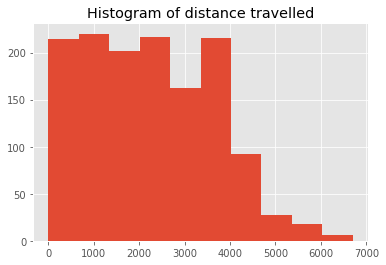

In [27]:
# Validate distance travelled
df_legs = gp.read_file(os.path.join(output_path, 'legs.geojson'))
df_legs.to_crs('EPSG:27700', inplace=True)
df_legs['length'] = df_legs.geometry.length

plt.hist(x='length', data=df_legs)
plt.title("Histogram of distance travelled")
plt.show()

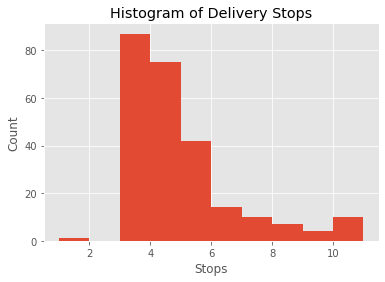

In [28]:
matplotlib.style.use('ggplot')

plot_data = df_activity[df_activity['activity']=='delivery'].groupby(['pid']).agg({'activity':'count'}).reset_index()
g = plt.hist(x = 'activity', data = plot_data)

plt.title('Histogram of Delivery Stops')
plt.xlabel('Stops')
plt.ylabel('Count')

plt.show()

In [29]:
write_od_matrices(population, path = output_path)
od_matrices = pd.read_csv(os.path.join(output_path, "total_od.csv")) 

In [30]:
freight_density = tour.ValidateTourOD(trips=trips,
                                      zone=zones,
                                      o_dist=origin_density,
                                      d_dist=destination_density,
                                      o_activity='depot',
                                      d_activity='delivery',
                                      o_freq='density',
                                      d_freq='density'
                                      )

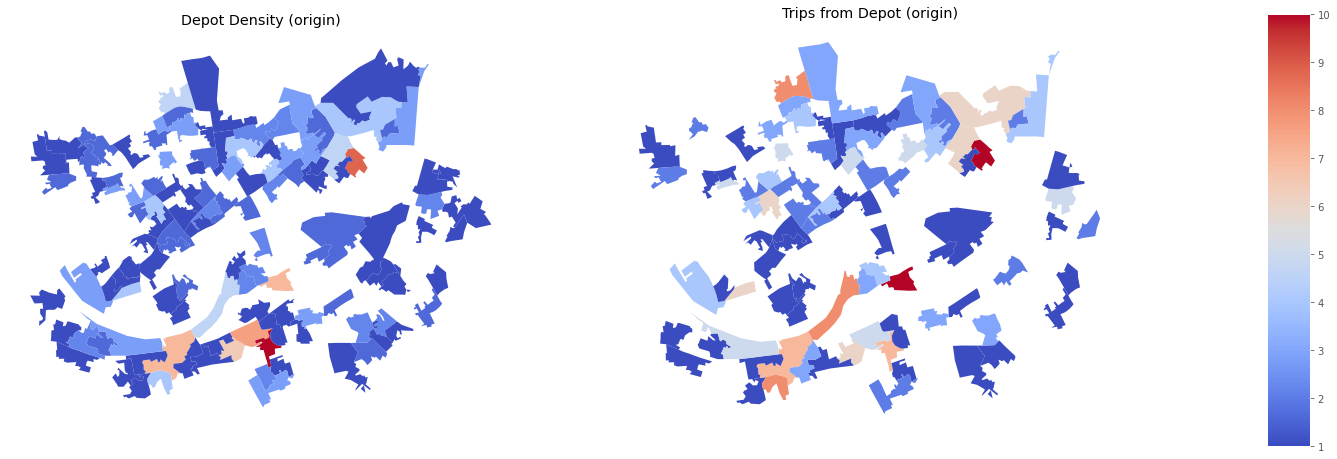

In [31]:
freight_density.plot_validate_spatial_density(title_1='Depot Density (origin)',
                                              title_2='Trips from Depot (origin)',
                                              density_metric='depot_density',
                                              density_trips='origin_trips'
                                              )

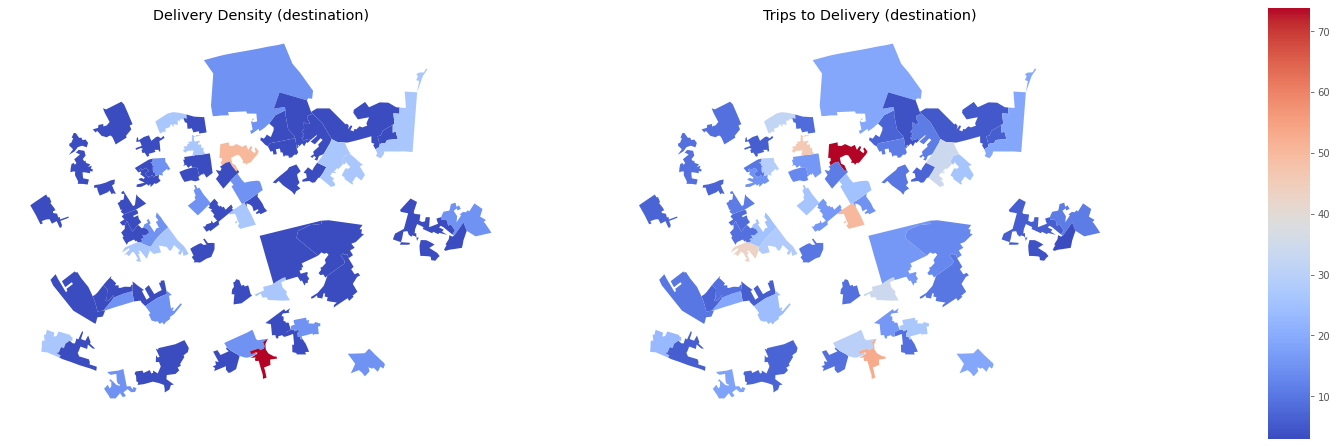

In [32]:
freight_density.plot_validate_spatial_density(title_1='Delivery Density (destination)',
                                              title_2='Trips to Delivery (destination)',
                                              density_metric='delivery_density',
                                              density_trips='destination_trips'
                                              )

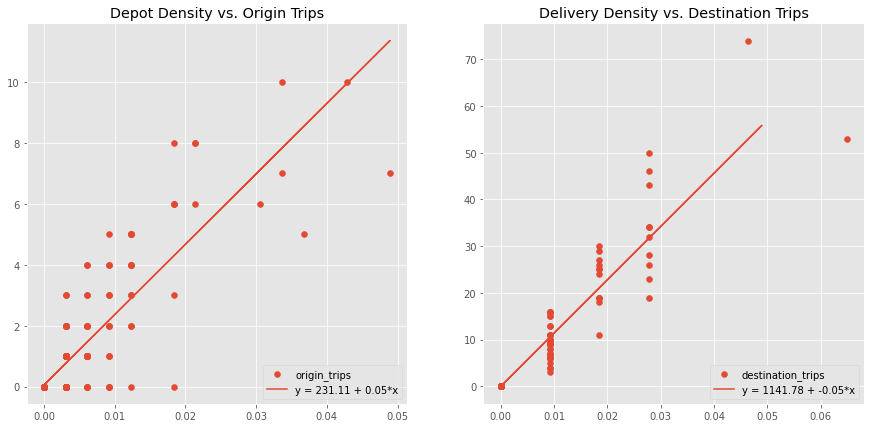

In [33]:
freight_density.plot_compare_density(title_1='Depot Density vs. Origin Trips',
                                     title_2='Delivery Density vs. Destination Trips',
                                     o_activity='depot_density',
                                     d_activity='delivery_density')